# Dask example

*This material is adapted from the [Dask tutorial documentation](https://tutorial.dask.org/00_overview.html) and the [Earth and Environmental Data Science](https://earth-env-data-science.github.io/intro.html) website.*


:::{note}
A **Dask array** looks and feels a lot like a `Numpy` array.
:::

However, a dask array doesn't directly hold any data. Instead, it *symbolically* represents the computations needed to generate the data.

Nothing is actually computed until the actual numerical values are needed. This mode of operation is called **"lazy"**; it allows one to build up complex, large calculations symbolically before turning them over the scheduler for execution.

If we want to create a `Numpy` array of all ones, we do it like this:

In [1]:
import numpy as np
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

This array contains exactly 32 MB of data:

In [2]:
ones_np.nbytes / 1e6

32.0

Now let's create the same array using dask's array interface.

In [3]:
import dask.array as da

ones = da.ones(shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

The dask array representation reveals the concept of **"chunks"**. 

:::{note}
**"Chunks"** describes how the array is split into sub-arrays. We did not specify any chunks, so **Dask** just used one single chunk for the array. This is not much different from a Numpy array at this point.
:::

## Specifying Chunks

However, we could have split up the array into many chunks.

![Dask Arrays](http://dask.pydata.org/en/latest/_images/dask-array-black-text.svg)
_source: [Dask Array Documentation](http://dask.pydata.org/en/latest/array-overview.html)_

There are [several ways to specify chunks](http://dask.pydata.org/en/latest/array-creation.html#chunks).

Here, we will use a block shape.

In [4]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

Notice that we just see a symbolic representation of the array, including its:
- shape, 
- dtype, and 
- chunksize.

No data has been generated yet.

When we call `.compute()` on a Dask array, the computation is trigger and the Dask array becomes a Numpy array.

In [5]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In order to understand what happened when we called `.compute()`, we can visualize the Dask _graph_, the symbolic operations that make up the array

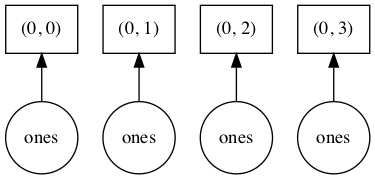

In [7]:
ones.visualize()

Our array has four chunks. To generate it, dask calls `np.ones` four times and then concatenates this together into one array.

Rather than immediately loading a dask array (which puts all the data into RAM), it is more common to want to reduce the data somehow. For example

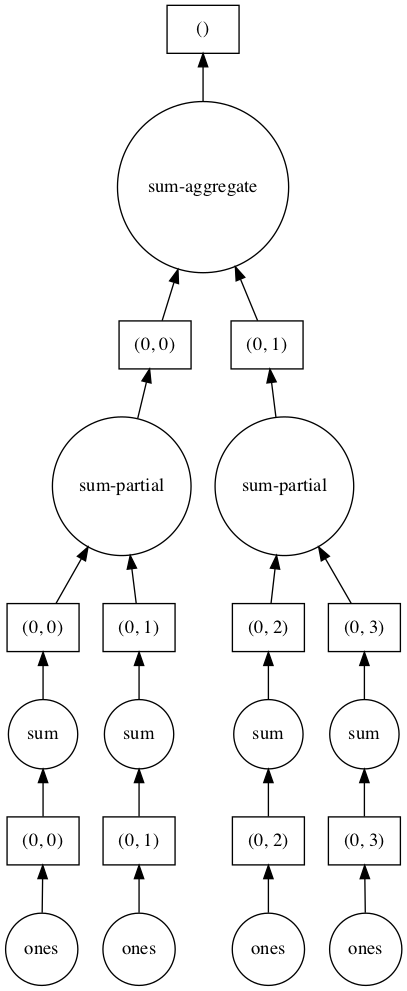

In [8]:
sum_of_ones = ones.sum()
sum_of_ones.visualize()

Here we see Dask's strategy for finding the sum. 

This simple example illustrates the beauty of Dask: **it automatically designs an algorithm appropriate for custom operations with big data.** 

If we make our operation more complex, the graph gets more complex.

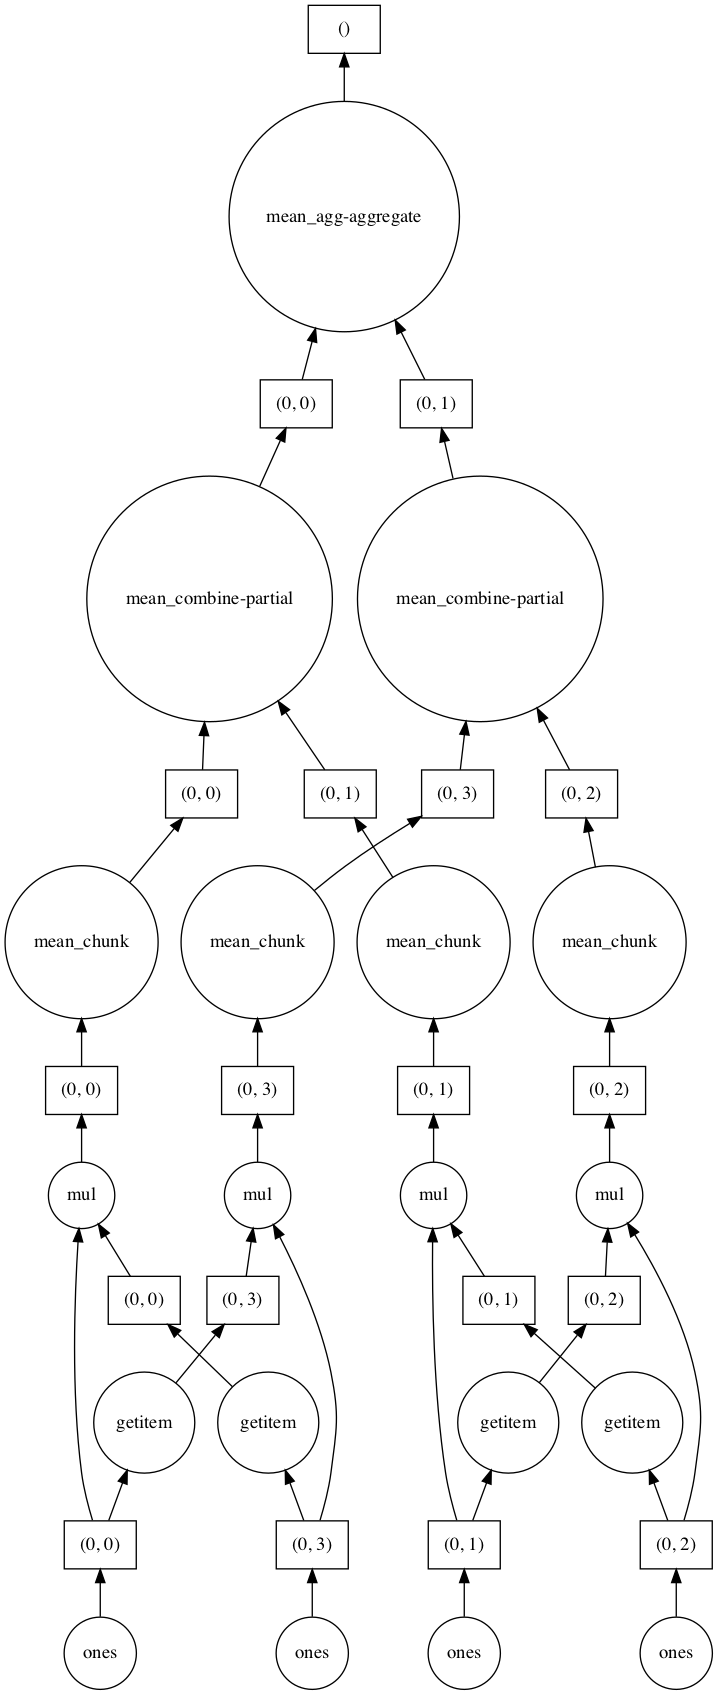

In [9]:
fancy_calculation = (ones * ones[::-1, ::-1]).mean()
fancy_calculation.visualize()

## A Bigger Calculation

The examples above were toy examples; the data (32 MB) is nowhere nearly big enough to warrant the use of dask.

We can make it a lot bigger!

In [10]:
bigshape = (200000, 4000)

big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones

dask.array<ones, shape=(200000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [11]:
big_ones.nbytes / 1e6

6400.0

This dataset is 6.4 GB, rather MB! This is probably close to or greater than the amount of available RAM than you have in your computer. Nevertheless, Dask has no problem working on it.

:::{danger}
Do not try to `.visualize()` this array!
:::

When doing a big calculation, Dask also has some tools to help us understand what is happening under the hood

In [12]:
from dask.diagnostics import ProgressBar

big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

with ProgressBar():
    result = big_calc.compute()
result

[########################################] | 100% Completed |  1.5s


1.0

### Reduction 

All the usual `Numpy` methods work on Dask arrays.

You can also apply numpy function directly to a Dask array, and it will stay lazy.

In [13]:
big_ones_reduce = (np.cos(big_ones)**2).mean(axis=0)
big_ones_reduce

dask.array<mean_agg-aggregate, shape=(4000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

Plotting also triggers computation, since we need the actual values

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (9,8)

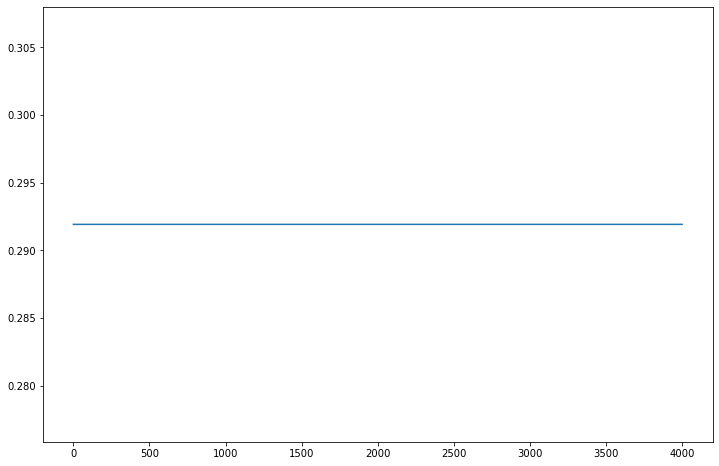

In [15]:
plt.plot(big_ones_reduce)

### Distributed Cluster

For more fancy visualization of what Dask is doing, we can use the [distributed scheduler](https://distributed.readthedocs.io/en/latest/).


In [17]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:59477 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 34.36 GB


In [18]:
big_calc.compute()

1.0

In [19]:
random_values = da.random.normal(size=(2e8,), chunks=(1e6,))
hist, bins = da.histogram(random_values, bins=100, range=[-5, 5]) 

In [20]:
hist

dask.array<sum-aggregate, shape=(100,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

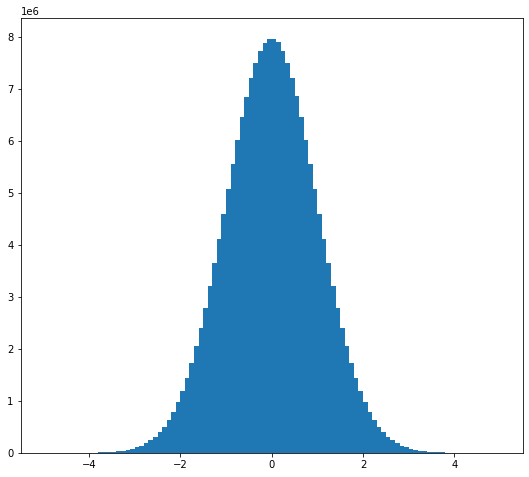

In [21]:
x = 0.5 * (bins[1:] + bins[:-1])
width = np.diff(bins)
hist_c = hist.compute()
plt.bar(x, hist_c, width);

## Dask + XArray

:::{important}
Everything has been commented below to speed-up the `Jupyter-book` creation!
:::

`Xarray` can automatically wrap its data in Dask arrays.


**This capability turns Xarray into an extremely powerful tool for Big Data Environmental science!!!**

To see this in action, we will download a fairly large dataset to analyze. 

This file contains 1 year of daily data from the [AVISO](http://www.aviso.oceanobs.com/en/data/products/index.html) sea-surface height satellite altimetry dataset.

In [23]:
#! wget http://www.ldeo.columbia.edu/~rpa/aviso_madt_2015.tar.gz

--2021-03-18 09:08:49--  http://www.ldeo.columbia.edu/~rpa/aviso_madt_2015.tar.gz
Resolving www.ldeo.columbia.edu... 129.236.14.15
Connecting to www.ldeo.columbia.edu|129.236.14.15|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.ldeo.columbia.edu/~rpa/aviso_madt_2015.tar.gz [following]
--2021-03-18 09:08:51--  https://www.ldeo.columbia.edu/~rpa/aviso_madt_2015.tar.gz
Connecting to www.ldeo.columbia.edu|129.236.14.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494834680 (472M) [application/x-gzip]
Saving to: 'aviso_madt_2015.tar.gz'

aviso_madt_2015.tar 100%[===================>] 471.91M  8.31MB/s    in 65s     

2021-03-18 09:09:57 (7.23 MB/s) - 'aviso_madt_2015.tar.gz' saved [494834680/494834680]



In [24]:
#! tar -xvzf aviso_madt_2015.tar.gz

x 2015/
x 2015/dt_global_allsat_madt_h_20150409_20150914.nc
x 2015/dt_global_allsat_madt_h_20150406_20150914.nc
x 2015/dt_global_allsat_madt_h_20150704_20160128.nc
x 2015/dt_global_allsat_madt_h_20150223_20150914.nc
x 2015/dt_global_allsat_madt_h_20151220_20160610.nc
x 2015/dt_global_allsat_madt_h_20150912_20160610.nc
x 2015/dt_global_allsat_madt_h_20150607_20160128.nc
x 2015/dt_global_allsat_madt_h_20150320_20150914.nc
x 2015/dt_global_allsat_madt_h_20150608_20160128.nc
x 2015/dt_global_allsat_madt_h_20150512_20160128.nc
x 2015/dt_global_allsat_madt_h_20151029_20160610.nc
x 2015/dt_global_allsat_madt_h_20150618_20160128.nc
x 2015/dt_global_allsat_madt_h_20150502_20160128.nc
x 2015/dt_global_allsat_madt_h_20151026_20160610.nc
x 2015/dt_global_allsat_madt_h_20150330_20150914.nc
x 2015/dt_global_allsat_madt_h_20150617_20160128.nc
x 2015/dt_global_allsat_madt_h_20150826_20160128.nc
x 2015/dt_global_allsat_madt_h_20150416_20150914.nc
x 2015/dt_global_allsat_madt_h_20150829_20160128.nc
x 20

In [25]:
#! ls 2015 | wc -l

     365


Let's load the first file as a regular xarray dataset.

In [26]:
#import xarray as xr

In [27]:
# ds_first = xr.open_dataset('2015/dt_global_allsat_madt_h_20150101_20150914.nc')
# ds_first

<xarray.Dataset>
Dimensions:   (lat: 720, lon: 1440, nv: 2, time: 1)
Coordinates:
  * time      (time) datetime64[ns] 2015-01-01
  * lat       (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * nv        (nv) int32 0 1
Data variables:
    lat_bnds  (lat, nv) float32 ...
    lon_bnds  (lon, nv) float32 ...
    crs       int32 ...
    adt       (time, lat, lon) float64 ...
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Absolute Dynamic Topography
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    ...                              ...
    summary:                         Delayed-Time Level-4 sea surface height ...
    time_coverage_duration:          P1D
    time_coverage_end:               2015-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2014-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [28]:
# ds_first.nbytes / 1e6

8.32034

This one file is about 8 MB. So 365 of them will be nearly 3 GB. If we had downloaded all 25 years of data, it would be 73 GB. This is a good example of "medium data."

### open_mfdataset

We already saw an incredibly useful function in xarray is `open_mfdataset`.

Using `open_mfdataset` we can easily open all the netcdf files into one `Dataset` object.

:::{tip}
If you got a *"Too many open files"* OSError. You will have to increase your `ulimit` from the command line before launching the notebook:

$ ulimit -S -n 4000
:::

In [29]:
# ds = xr.open_mfdataset('2015/*.nc')
# ds

<xarray.Dataset>
Dimensions:   (lat: 720, lon: 1440, nv: 2, time: 365)
Coordinates:
  * time      (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
  * lat       (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * nv        (nv) int32 0 1
Data variables:
    lat_bnds  (time, lat, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds  (time, lon, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    crs       (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    adt       (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Absolute Dynamic Topography
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    ...                              ...
    summary:                         Delayed-Time Level-4 sea surface height ...
    time_coverage_duration:          P1D
    time_coverage_end:               2015-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2014-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

Note that the values are not displayed, since that would trigger computation.

In [30]:
# ssh = ds.adt
# ssh

<xarray.DataArray 'adt' (time: 365, lat: 720, lon: 1440)>
dask.array<concatenate, shape=(365, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Attributes:
    grid_mapping:   crs
    long_name:      Absolute Dynamic Topography
    standard_name:  sea_surface_height_above_geoid
    units:          m

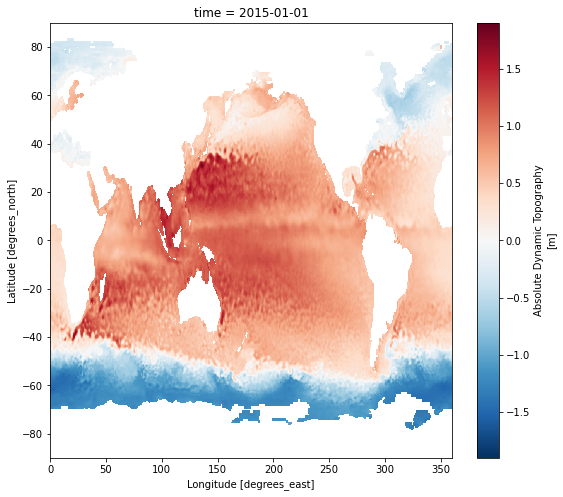

In [31]:
# ssh[0].plot()

In [32]:
# ssh_2015_mean = ssh.mean(dim='time')
# ssh_2015_mean.load()

<xarray.DataArray 'adt' (lat: 720, lon: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9

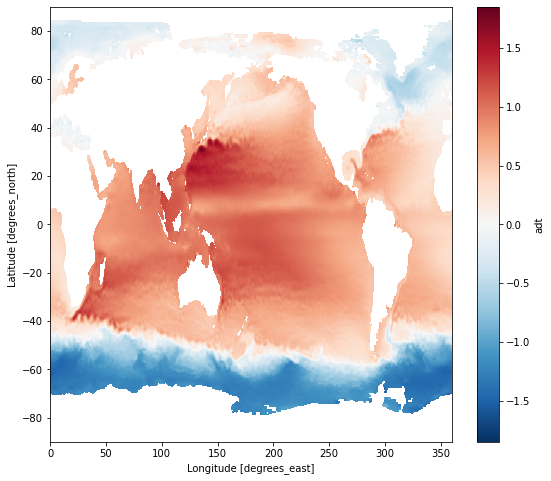

In [33]:
# ssh_2015_mean.plot()

In [34]:
# ssh_anom = ssh - ssh_2015_mean
# ssh_variance_lonmean = (ssh_anom**2).mean(dim=('lon', 'time'))

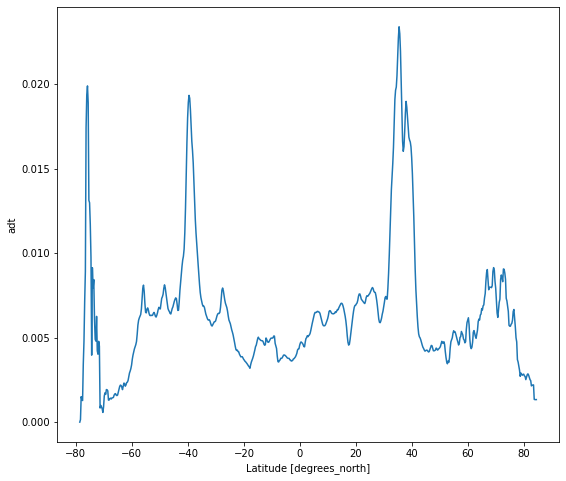

In [35]:
# ssh_variance_lonmean.plot()

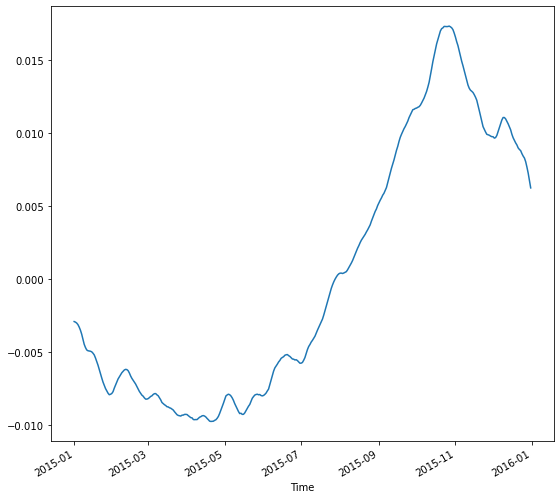

In [36]:
# weight = np.cos(np.deg2rad(ds.lat))
# weight /= weight.mean()
# (ssh_anom * weight).mean(dim=('lon', 'lat')).plot()

## Cloud Storage

Since we are in the cloud, we can also skip the whole "download" step and just work with data stored directly in cloud storage.

There are a lot of different pieces that make this work:
- [Pangeo Cloud Data Catalog](https://pangeo-data.github.io/pangeo-datastore/)
- [Intake](https://intake.readthedocs.io/)
- [Zarr](https://zarr.readthedocs.io/)

We don't have time to go over them all.

But here is an example from **Pangeo**:

+ https://catalog.pangeo.io/browse/master/ocean/sea_surface_height/

In [44]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
list(cat)

['sea_surface_height',
 'cesm_mom6_example',
 'ECCOv4r3',
 'SOSE',
 'GODAS',
 'ECCO_layers',
 'altimetry',
 'LLC4320',
 'GFDL_CM2_6',
 'CESM_POP',
 'channel',
 'MEOM_NEMO']

In [46]:
# ds = cat["sea_surface_height"].to_dask()
# ds

In [48]:
# ds.sla.data